In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon
import seaborn as sns
from sklearn.neighbors import KernelDensity
import rasterio as rio
from shapely.ops import unary_union

## Loading and Reprojecting Data

### Parks

In [3]:
parks_gdf = gpd.read_file('Final Data/seattle_parks')
parks_gdf.head()

,NAME,geometry
0,12TH AVE SQUARE PARK,"POLYGON ((-122.31625 47.60714, -122.31625 47.6..."
1,14TH AVENUE NW BOAT RAMP,"POLYGON ((-122.37380 47.66139, -122.37380 47.6..."
2,17TH AVENUE NE CENTERSTRIP,"MULTIPOLYGON (((-122.30952 47.66651, -122.3095..."
3,3001 E MADISON,"POLYGON ((-122.29280 47.62507, -122.29283 47.6..."
4,48TH AVE SW/SW CHARLESTOWN ST,"POLYGON ((-122.39356 47.56986, -122.39356 47.5..."


In [4]:
#Use centroid and project
parks_gdf_proj = parks_gdf.to_crs('EPSG:32610')
parks_gdf_proj['geometry'] = parks_gdf_proj['geometry'].centroid

### Retail

In [5]:
retail_gdf= gpd.read_file('Final Data/seattle_retail')
retail_gdf.head()

,shop,name,geometry
0,books,University Book Store,POINT (-122.31298 47.66040)
1,car_repair,Midas,POINT (-122.30147 47.70906)
2,supermarket,Grocery Outlet,POINT (-122.29521 47.72164)
3,car,Pierre Chevrolet,POINT (-122.30051 47.71129)
4,bakery,Cupcake Royale,POINT (-122.38656 47.56122)


In [6]:
retail_gdf_proj = retail_gdf.to_crs('EPSG:32610')
retail_gdf_proj['geometry'] = retail_gdf_proj['geometry'].centroid

### Culture, Leisure, Amenities

In [7]:
cla_gdf = gpd.read_file('Final Data/culture_leisure_amenities')
cla_gdf.head()

,amenity,name,geometry
0,slipway,None,POINT (-122.27676 47.57115)
1,slipway,None,POINT (-122.29946 47.64835)
2,slipway,Ferdinand Street Boat Launch,POINT (-122.26151 47.55734)
3,slipway,None,POINT (-122.39745 47.54028)
4,picnic_table,None,POINT (-122.33925 47.69838)


In [8]:
cla_gdf_proj = cla_gdf.to_crs('EPSG:32610')
cla_gdf_proj.geometry.geom_type.unique()

array(['Point', 'Polygon', 'LineString', 'MultiPolygon'], dtype=object)

In [9]:
#Remove linestring objects. They don't have centroid.
cla_gdf_proj = cla_gdf_proj[cla_gdf_proj.geometry.geom_type != 'LineString']

In [10]:
cla_gdf_proj['geometry'] = cla_gdf_proj['geometry'].centroid

### Transit

In [11]:
transit_gdf= gpd.read_file('Final Data/Seattle_Transit_Stops')
transit_gdf.head()

,OBJECTID,CHANGE_NUM,MINOR_CHANGE_NUM,ACCESSIBILITY_DECAL,ACCESSORY_SIGN,STOP_ID,TRANS_LINK_ID,STOP_STATUS,STOP_TYPE,AUTH_CODE,...,ON_STREET_NAME,ROUTESIGN,ROUTESIGN_OWNER,SIGN_MOUNTING_DIR,SIGNPOST,SIGNPOST_ANCHOR,SCHEDULE_HOLDER,NUM_SHELTERS,GISOBJID,geometry
0,20215,150,0,UNK,Unknown,26150,79389,CLO,REG,UNK,...,37th Ave NE,Unknown,UNK,None,Unknown,Unknown,UNK,0,100015310.0,POINT (-122.28871 47.72321)
1,5310,149,10,UNK,Unknown,26150,79389,CLO,REG,UNK,...,37th Ave NE,Unknown,UNK,None,Unknown,Unknown,UNK,0,100015310.0,POINT (-122.28871 47.72321)
2,13882,149,10,YES,None,76730,18073,ACT,REG,SEA,...,Lake City Way NE,A2 <=6 rts,KCM,Away,Light,Unknown,Double,1,8074.0,POINT (-122.29289 47.72333)
3,15134,150,0,YES,None,76730,18073,ACT,REG,SEA,...,Lake City Way NE,A2 <=6 rts,KCM,Away,Light,Unknown,Double,1,8074.0,POINT (-122.29289 47.72333)
4,22355,150,0,UNK,Unknown,38659,29894,ACT,LAY,UNK,...,35th Ave NE,Unknown,UNK,None,Unknown,Unknown,UNK,0,100016122.0,POINT (-122.29095 47.72339)


In [12]:
transit_gdf_proj = transit_gdf.to_crs('EPSG:32610')

### Sidewalks

In [13]:
sidewalks_gdf= gpd.read_file('Final Data/seattle_sidewalks')
sidewalks_gdf.head()

,geometry
0,"LINESTRING (-122.37013 47.70341, -122.37136 47..."
1,"LINESTRING (-122.37373 47.65556, -122.37448 47..."
2,"LINESTRING (-122.37171 47.65470, -122.37232 47..."
3,"LINESTRING (-122.37152 47.65484, -122.37214 47..."
4,"LINESTRING (-122.36763 47.65230, -122.37005 47..."


In [14]:
sidewalks_gdf_proj = sidewalks_gdf.to_crs('EPSG:32610')

In [15]:
sidewalks_gdf_proj=sidewalks_gdf_proj.dropna()

In [16]:
sidewalks_gdf_proj.to_file('seattle_sidewalks_proj')

In [19]:
#test code for converting linestrings to points
test = sidewalks_gdf_proj['geometry'][:3]
test

0    LINESTRING (547253.884 5283528.262, 547162.044...
1    LINESTRING (547026.699 5278208.530, 546971.126...
2    LINESTRING (547179.633 5278113.482, 547132.962...
Name: geometry, dtype: geometry

In [20]:
test1 = test.copy()
test1

0    LINESTRING (547253.884 5283528.262, 547162.044...
1    LINESTRING (547026.699 5278208.530, 546971.126...
2    LINESTRING (547179.633 5278113.482, 547132.962...
Name: geometry, dtype: geometry

In [21]:
#test code for converting linestrings to points
distance_delta = 800
for i in range(len(test)):
    distances = np.arange(0, test[i].length, distance_delta)
    points = [test[i].interpolate(distance) for distance in distances] + [test[i].boundary.geoms[1]]
    multipoint = unary_union(points)
    test1[i] = multipoint
    print('.',end='')


...

In [22]:
ped_net_geo_line = sidewalks_gdf_proj['geometry']

In [23]:
ped_net_geo_line.geometry.geom_type.unique()

array(['LineString', 'MultiLineString'], dtype=object)

In [24]:
#Remove Multiline string objects from geometry. They don't work well in creating points from linestrings
ped_net_geo_line=ped_net_geo_line[ped_net_geo_line.geom_type != 'MultiLineString']

In [32]:
ped_net_geo_line.geometry.geom_type.unique()

array(['LineString'], dtype=object)

In [25]:
ped_net_geo_mpoint = ped_net_geo_line.copy()

In [ ]:
#Convert lines into points that are spaces 800m apart
distance_delta = 800
for i in range(len(ped_net_geo_line)):
    distances = np.arange(0, ped_net_geo_line.iloc[i].length, distance_delta)
    points = [ped_net_geo_line.iloc[i].interpolate(distance) for distance in distances] + [ped_net_geo_line.iloc[i].boundary.geoms[1]]
    multipoint = unary_union(points)
    ped_net_geo_mpoint[i] = multipoint
    #print(i,end='')

In [ ]:
#Turn Multipoints into points so KDE plot can work
ped_points = []
for i in range(len(ped_net_geo_mpoint)):
    for x in range(len(ped_net_geo_mpoint[i].geoms)):
        ped_points.append(ped_net_geo_mpoint[i].geoms[x])

In [30]:
ped_points_gdf = gpd.GeoSeries(data=ped_points)

In [31]:
#For testing since the above loops take so long
#ped_points_gdf.to_file('ped_points',driver='GeoJSON')

### Neighborhoods

In [90]:
hood_gdf = gpd.read_file('Final Data/Neighborhoods_Community_Reporting_Areas.geojson')

In [34]:
hood_gdf = hood_gdf[['GEN_ALIAS','geometry']]

In [35]:
hood_gdf_proj = hood_gdf.to_crs('EPSG:32610')

<AxesSubplot:>

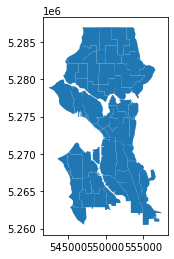

In [36]:
hood_gdf_proj.plot()

## Analysis

### Density of Elements of Walkability

In [ ]:
data_dict = {"Seattle Culture, Entertainment, Amentities": cla_gdf_proj,
               "Seattle Parks": parks_gdf_proj,
               "Seattle Retail": retail_gdf_proj,
               "Seattle Transit": transit_gdf_proj,
               "Seattle Pedestrian Network": ped_points_gdf
            }

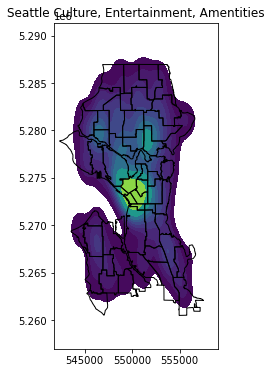

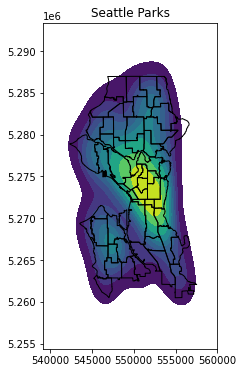

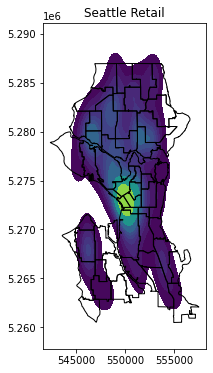

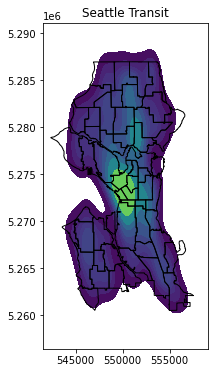

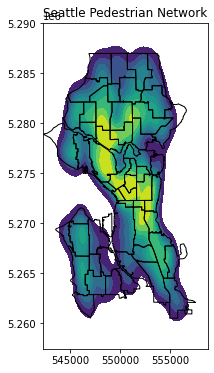

In [ ]:
for layer in data_dict.keys():
    f, ax = plt.subplots(figsize=(6, 6))
    sns.kdeplot(data=data_dict[layer],x=data_dict[layer].geometry.x,y=data_dict[layer].geometry.y,shade=True, cmap='viridis')
    ax.set_title(layer)
    hood_gdf_proj.plot(ax=ax,facecolor='none', edgecolor='k')

## Saving Density Plots

### Parks

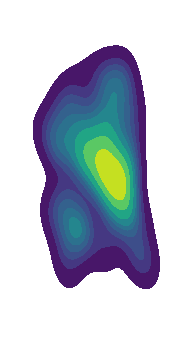

In [88]:
f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(data=parks_gdf_proj,x=parks_gdf_proj.geometry.x,y=parks_gdf_proj.geometry.y,shade=True, cmap='viridis')
hood_gdf_proj.plot(ax=ax,facecolor='none', edgecolor='none')
ax.set_axis_off()
f.savefig("Rasterized Images/parks_raster.png", dpi=300)

### Retail

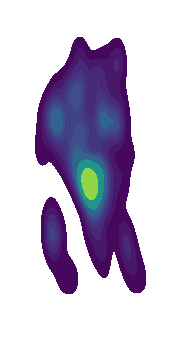

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(data=retail_gdf_proj,x=retail_gdf_proj.geometry.x,y=retail_gdf_proj.geometry.y,shade=True, cmap='viridis')
hood_gdf_proj.plot(ax=ax,facecolor='none', edgecolor='none')
ax.set_axis_off()
f.savefig("Rasterized Images/retail_raster.png", dpi=300)

### Transit

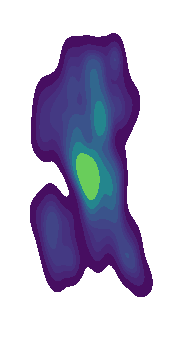

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(data=transit_gdf_proj,x=transit_gdf_proj.geometry.x,y=transit_gdf_proj.geometry.y,shade=True, cmap='viridis')
hood_gdf_proj.plot(ax=ax,facecolor='none', edgecolor='none')
ax.set_axis_off()
f.savefig("Rasterized Images/transit_raster.png", dpi=300)

### Amenities, Culture, and Entertainment

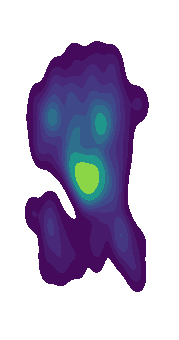

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(data=cla_gdf_proj,x=cla_gdf_proj.geometry.x,y=cla_gdf_proj.geometry.y,shade=True, cmap='viridis')
hood_gdf_proj.plot(ax=ax,facecolor='none', edgecolor='none')
ax.set_axis_off()
f.savefig("Rasterized Images/cla_raster.png", dpi=300)

### Pedestrian Network

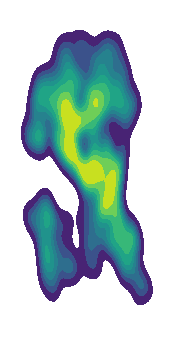

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
sns.kdeplot(data=ped_points_gdf,x=ped_points_gdf.geometry.x,y=ped_points_gdf.geometry.y,shade=True, cmap='viridis')
hood_gdf_proj.plot(ax=ax,facecolor='none', edgecolor='none')
ax.set_axis_off()
f.savefig("Rasterized Images/ped_raster.png", dpi=300)

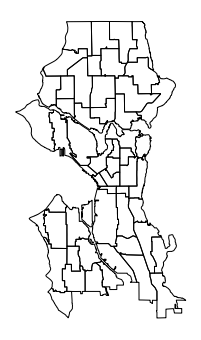

In [ ]:
f, ax = plt.subplots(figsize=(6, 6))
hood_gdf_proj.plot(ax=ax,facecolor='none', edgecolor='k')
ax.set_axis_off()
f.savefig("Rasterized Images/hood_raster.png", dpi=300)